# Integrating a Force Step

Here we show how to add force steps before and after a REBOUND timestep. This can be important if the force is velocity-dependent and you are using WHFast, since it assumes that additional forces are only position-dependent. Velocity-dependent forces have to be integrated across the timestep

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def system():
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=0.93)
    sim.add(m=4.5*3.e-7, P=0.571/365.25, e=0.01)
    sim.add(m=41.*3.e-7, P=13.34/365.25, e=0.01)
    sim.move_to_com()
    sim.dt = 0.07*sim.particles[1].P
    return sim

If we simply add the GR force and integrate as normal with WHFast, the energy error will grow secularly (see REBOUNDx paper):

In [2]:
sim = system()
sim.integrator = "whfast"

In [3]:
import reboundx

rebx = reboundx.Extras(sim)
gr = rebx.load_force("gr")
rebx.add_force(gr)
gr.params["c"] = 63197.8# AU/yr

In [4]:
Nout = 1000
times = np.linspace(0, 1e4*sim.particles[1].P, Nout)
E0 = rebx.gr_hamiltonian(gr)
Eerr = np.zeros(Nout)

for i, time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    E = rebx.gr_hamiltonian(gr)
    Eerr[i] = np.abs((E-E0)/E0)

Text(0,0.5,'Relative Energy Error')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


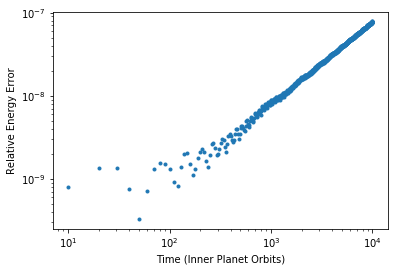

In [5]:
fig, ax = plt.subplots()
ax.loglog(times/sim.particles[1].P, Eerr, '.')
ax.set_xlabel('Time (Inner Planet Orbits)')
ax.set_ylabel('Relative Energy Error')

If instead we add an operator step before and after the timestep that integrates the GR force across it, we fix the problem. We again load the gr force, but instead of adding it to rebx, we instead add an 'integrate_force' operator, and add the gr force as a parameter to that operator step:

In [6]:
sim = system()
sim.integrator = "whfast"

rebx = reboundx.Extras(sim)
gr = rebx.load_force("gr")
gr.params["c"] = 63197.8# AU/yr

intforce = rebx.load_operator('integrate_force')
rebx.add_operator(intforce)
intforce.params['force'] = gr
intforce.params['integrator'] = 0 # implicit_midpoint

Above we have also chosen which integrator to use across the timestep, here implicit midpoint. See the REBOUNDx paper for more discussion

In [7]:
Nout = 1000
times = np.linspace(0, 1e4*sim.particles[1].P, Nout)
E0 = rebx.gr_hamiltonian(gr)
Eerr = np.zeros(Nout)

for i, time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    E = rebx.gr_hamiltonian(gr)
    Eerr[i] = np.abs((E-E0)/E0)

Text(0,0.5,'Relative Energy Error')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


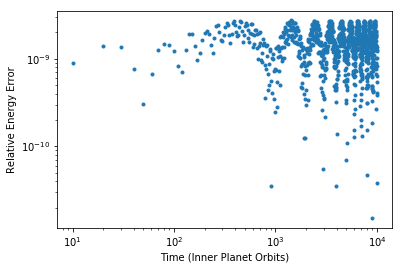

In [8]:
fig, ax = plt.subplots()
ax.loglog(times/sim.particles[1].P, Eerr, '.')
ax.set_xlabel('Time (Inner Planet Orbits)')
ax.set_ylabel('Relative Energy Error')